In [1]:
# Core
import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras import regularizers


In [2]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [3]:
BATCH_SIZE = 8
n_splits = 5
fold_selected = 2   # 1,...,5
im_width = 256
im_height = 256

In [4]:
# Train set
train_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [5]:
# Test set
test_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = train_df.iloc[:10*16*3,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"predicted"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


In [6]:
# Metadata
def preprocessing(df, subset="train"):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    if (subset=="train") or (DEBUG):
        DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [7]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [8]:
test_df=preprocessing(test_df, subset="test")
test_df.head()

,id,class,predicted,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266


In [9]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [10]:
train_df=restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266,0


In [11]:
test_df=restructure(test_df, subset="test")
test_df.head()

,id,path,case,day,slice,width,height
0,case123_day20_slice_0001,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0001,266,266
1,case123_day20_slice_0002,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0002,266,266
2,case123_day20_slice_0003,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0003,266,266
3,case123_day20_slice_0004,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0004,266,266
4,case123_day20_slice_0005,../input/uw-madison-gi-tract-image-segmentatio...,123,20,0005,266,266


In [12]:
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [13]:
# Garbage collection
gc.collect()

46

In [14]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [15]:
from tensorflow.keras import backend as K
import tensorflow as tf

smooth = 1.0

# --------- Channel-wise Dice ---------
def dice_coef_channel(y_true, y_pred, channel_idx):
    y_true_c = y_true[..., channel_idx]
    y_pred_c = y_pred[..., channel_idx]
    y_true_f = K.flatten(tf.cast(y_true_c, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred_c, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_large_bowel(y_true, y_pred):
    return dice_coef_channel(y_true, y_pred, 0)

def dice_coef_small_bowel(y_true, y_pred):
    return dice_coef_channel(y_true, y_pred, 1)

def dice_coef_stomach(y_true, y_pred):
    return dice_coef_channel(y_true, y_pred, 2)

# --------- Channel-wise IoU ---------
def iou_coef_channel(y_true, y_pred, channel_idx):
    y_true_c = y_true[..., channel_idx]
    y_pred_c = y_pred[..., channel_idx]
    y_true_f = K.flatten(tf.cast(y_true_c, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred_c, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_coef_large_bowel(y_true, y_pred):
    return iou_coef_channel(y_true, y_pred, 0)

def iou_coef_small_bowel(y_true, y_pred):
    return iou_coef_channel(y_true, y_pred, 1)

def iou_coef_stomach(y_true, y_pred):
    return iou_coef_channel(y_true, y_pred, 2)

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Intersection over Union coefficient
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [16]:
from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred) 

def loss_e(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred)  + kld(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [17]:
# Images reshaped to (im_height,im_width)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,im_height,im_width,3))
        y = np.empty((self.batch_size,im_height,im_width,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (im_height,im_width,1)
            X[i,] = img   # broadcast to shape: (im_height,im_width,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (im_height,im_width))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
        # To do: add data augmentation
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (im_height,im_width)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

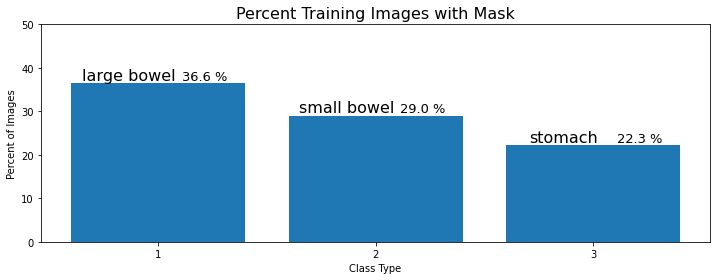

In [18]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean(train_df.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect, lbl in zip(bar, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50))
plt.show()

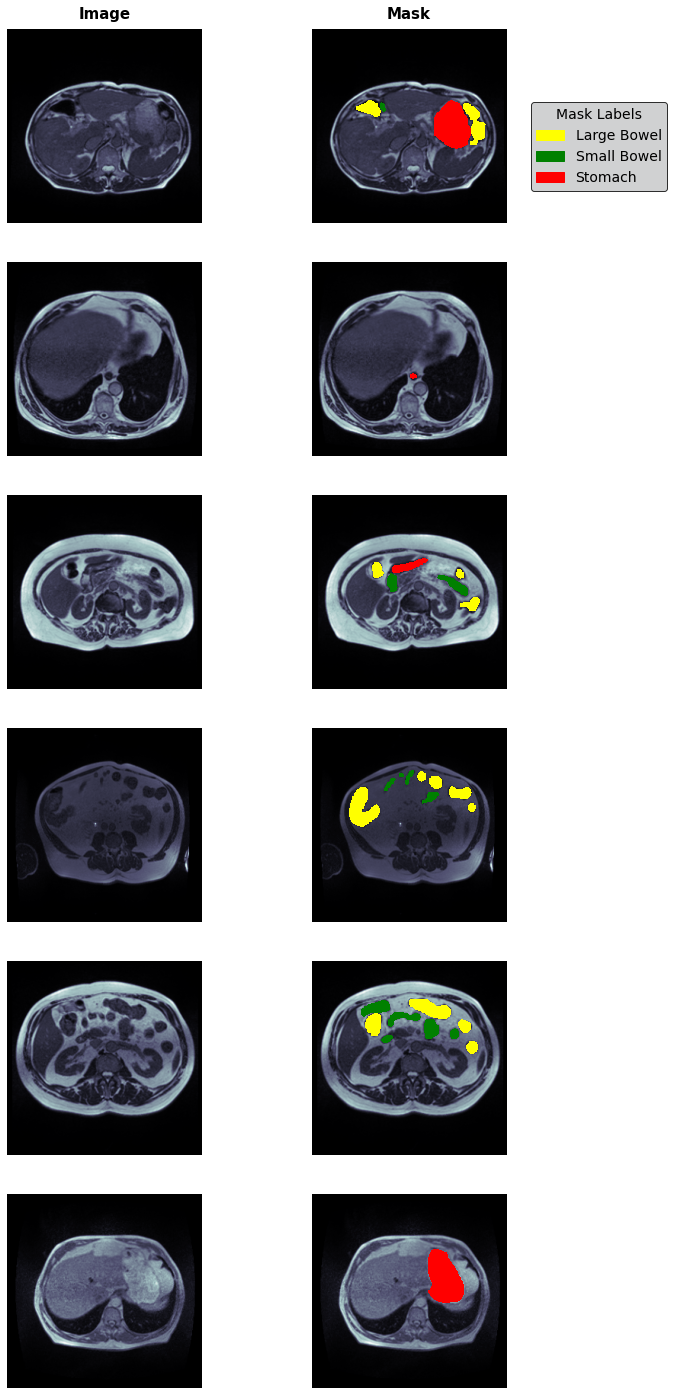

In [19]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)

# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

In [20]:
# Extract only the case number (ignore day)
train_df['case_only'] = train_df.iloc[:, 0].str.extract(r'(case\d+)')

# Get unique case IDs
unique_cases = train_df['case_only'].unique()

# First 70 for training, next 15 for validation
train_cases = unique_cases[:70]
valid_cases = unique_cases[70:85]

# Create splits based on case_only
X_train = train_df[train_df['case_only'].isin(train_cases)]
X_valid = train_df[train_df['case_only'].isin(valid_cases)]

# Check
print("Training set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Training cases:", X_train['case_only'].nunique())
print("Validation cases:", X_valid['case_only'].nunique())


Training set size: 30496
Validation set size: 7712
Training cases: 70
Validation cases: 15


In [21]:
# Check submission format works
experimental=False
if experimental:
    X_train=X_train[X_train.case.isin(X_train.case.unique()[:5])]       # take first few cases
    X_valid=X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]       # take first few cases
    
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (30496, 12)
X_valid shape: (7712, 12)


In [22]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Multiply, Conv2D, DepthwiseConv2D, Dense, Flatten, MaxPooling2D, UpSampling2D, concatenate, Activation, LayerNormalization, Add, Dropout, Conv2DTranspose, multiply, Reshape, GlobalAveragePooling2D, Permute, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate

def activation_block(x):
    x = Activation("gelu")(x)
    return LayerNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = Conv2D(filters, kernel_size=patch_size,padding='same', strides=patch_size)(x)
    return activation_block(x)

def vector_block(xyz, cmf, red):
    # red means reduction
    # cmf means filters, denotes vector size
    opt1 = conv_stem(xyz, cmf, red)
    opt2 = conv_stem(xyz, cmf, red)
    
    o1 = GlobalAveragePooling2D()(opt1)
    o2 = GlobalAveragePooling2D()(opt2)

    o5 = concatenate([o1, o2], -1)
    return o5

def mlp_feature(vect, cmf):
    oo = Flatten()(vect)
    o6 = Dense(cmf, activation='gelu')(oo)
    o6 = Dropout(0.2)(o6)
    o6 = Dense(cmf * 2, activation='gelu')(o6)

    o6 = Reshape((1, cmf * 2))(o6)
    o7 = Permute((2, 1))(o6)

    o8 = multiply([o6, o7])
    
    o8 = Lambda(lambda x: tf.expand_dims(x, -1))(o8)
    
    o8 = Reshape((cmf, cmf, 4))(o8)

    return o8

def frz_block(xyz):
    shape = xyz.shape
    a1, a2, a3, a4 = shape[0], shape[1], shape[2], shape[3]
    cmf = a2
    o5 = vector_block(xyz, cmf, 5)
    o7 = mlp_feature(o5, cmf)

    o7 = concatenate([o7, xyz, o7], -1)
    return o7

def up_frz(x1, x2, n_filters):
    # Upsample x1 using Conv2DTranspose
    x1 = Conv2DTranspose(n_filters * 4, 3, strides=2, activation='gelu', padding="same")(x1)
    
    # Apply Conv2D to x2
    x2 = Conv2D(n_filters * 2, 3, activation='gelu', padding="same")(x2)
    
    # Apply attention mechanism
    x = concatenate([x1, x2])
    
    # Apply Dropout for regularization
    x = Dropout(0.3)(x)
    
    return x

In [24]:
def squeeze_and_excite_block(inputs, ratio=24):
    """ Squeeze and Excitation block to recalibrate channel-wise features """
    filters = inputs.shape[-1]  # Number of input channels
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape(se_shape)(se)

    a = filters // ratio

    # Excitation: Dense layers to capture channel-wise dependencies
    if a > 8:
        se = Conv2D(filters // ratio, kernel_size=1, activation='swish', padding='same')(se)
        se = Conv2D(filters, kernel_size=1, activation='sigmoid', padding='same')(se)
    else:
        se = Conv2D(8, kernel_size=1, activation='swish', padding='same')(se)
        se = Conv2D(filters, kernel_size=1, activation='sigmoid', padding='same')(se)

    # Scale the input by channel-wise weights
    x = multiply([inputs, se])

    return x



def dense_block(inputs, num_layers, growth_rate, ratio=16):
    """Dense block where each layer is connected to all previous layers."""
    concat_features = inputs
    for i in range(num_layers):
        # BatchNorm -> ReLU -> Conv2D
        x = Conv2D(growth_rate, 3, activation='gelu', padding='same')(concat_features)

        # Concatenate input with new output (dense connection)
        concat_features = Concatenate()([concat_features, x])

    x = squeeze_and_excite_block(concat_features)

    return x



inputs = (im_height, im_width, 3)

def model_build_func(input_shape, n_labels):
    inputs = Input(shape=input_shape, name='input_image')
    g_filter = 16
    u_filter = 8

    # Initial convolution
    initial = Conv2D(g_filter, (3, 3), activation='gelu', padding="same")(inputs)
    initial = dense_block(initial, 2, g_filter // 2)  # 80

    # Down-sampling path
    o1 = MaxPooling2D(2)(initial)
    o1 = frz_block(dense_block(o1, 2, g_filter))  # 40

    o2 = MaxPooling2D(2)(o1)
    o2 = frz_block(dense_block(o2, 2, g_filter * 2))  # 20

    o3 = MaxPooling2D(2)(o2)
    o3 = frz_block(dense_block(o3, 2, g_filter * 4))  # 10

    o4 = MaxPooling2D(2)(o3)
    o4 = frz_block(dense_block(o4, 2, g_filter * 8))  # 5

    o5 = MaxPooling2D(2)(o4)
    o5 = frz_block(dense_block(o5, 2, g_filter * 16))  # 5

    # Up-sampling path
    u1 = up_frz(o5, o4, u_filter * 16)  # 10
    #gate1 = attention_gate(o4, u1, u_filter * 16, attention='add')
    cu1 = concatenate([u1, o4])

    u2 = up_frz(cu1, o3, u_filter * 8)  # 20
    #gate2 = attention_gate(o3, u2, u_filter * 8, attention='add')
    cu2 = concatenate([u2, o3])  # 20

    u3 = up_frz(cu2, o2, u_filter * 4)  # 40
    #gate3 = attention_gate(o2, u3, u_filter * 4, attention='add')
    cu3 = concatenate([u3, o2])  # 40

    u4 = up_frz(cu3, o1, u_filter * 2)  # 80
    #gate4 = attention_gate(o1, u4, u_filter * 2, attention='add')
    cu4 = concatenate([u4, o1])  # 80

    u5 = Conv2DTranspose(u_filter * 4, 3, strides=2, activation='gelu', padding="same")(cu4)  # 80
    #gate5 = attention_gate(initial, u5, u_filter, attention='add')
    cu5 = concatenate([u5, initial])  # 80

    # Final segmentation map
    seg_map = Conv2D(n_labels, 3, activation='sigmoid', padding="same")(cu5)

    # Model definition
    model = Model(inputs=inputs, outputs=seg_map)

    return model


upp = model_build_func(inputs, 3)

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model):
    """Calculate Floating Point Operations (FLOPs) of a Keras model in TensorFlow 2.x."""
    # Convert Keras model to a TensorFlow function
    concrete_func = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.input.dtype)
    )

    # Convert to frozen graph
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)

    # Compute FLOPs
    flops = tf.compat.v1.profiler.profile(
        frozen_func.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation(),
    )

    return flops.total_float_ops

# Compute FLOPs
flops = get_flops(upp)
print(f"Total FLOPs: {flops / 1e9:.2f} GFLOPs")  # Convert to GFLOPs



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

In [25]:
upp.compile(optimizer='adam', loss=loss_f, metrics=[dice_coef, dice_coef_large_bowel, dice_coef_small_bowel, dice_coef_stomach, iou_coef, iou_coef_large_bowel, iou_coef_small_bowel, iou_coef_stomach])

# Model summary
upp.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  1160        conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 24) 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [26]:
!pip install openpyxl

import openpyxl
import pandas as pd
import tensorflow as tf
import os
import shutil
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

# Define file paths
checkpoint_filepath = '/kaggle/working/checkpoint.h5.keras'
metrics_file = '/kaggle/working/training_metrics.xlsx'
pre_checkpoint_filepath = '/kaggle/input/efficientnetb3-paperformat-main-end/checkpoint.h5.keras'
pre_metrics_file = '/kaggle/input/efficientnetb3-paperformat-main-end/training_metrics.xlsx'

# Copy pre-existing checkpoint and metrics file to the working directory
if os.path.exists(pre_checkpoint_filepath):
    shutil.copy(pre_checkpoint_filepath, checkpoint_filepath)
    print(f"Restored checkpoint from: {pre_checkpoint_filepath}")

if os.path.exists(pre_metrics_file):
    shutil.copy(pre_metrics_file, metrics_file)
    print(f"Restored metrics file from: {pre_metrics_file}")

# Load last epoch and metrics if available
def load_last_epoch():
    if os.path.exists(metrics_file):
        df = pd.read_excel(metrics_file)
        if not df.empty:
            return df['epoch'].iloc[-1] + 1  # Resume from the next epoch
    return 0  # Start from scratch

last_epoch = load_last_epoch()

def get_best_val_loss():
    """Retrieve the lowest validation loss from the saved metrics file."""
    if os.path.exists(metrics_file):
        df = pd.read_excel(metrics_file)
        if 'val_loss' in df.columns and not df['val_loss'].isnull().all():
            return df['val_loss'].min()
    return float('inf')

best_val_loss = get_best_val_loss()

# Get best small bowel IoU
def get_best_val_iou_small_bowel():
    """Retrieve the best val_iou_coef_small_bowel from the saved metrics file."""
    if os.path.exists(metrics_file):
        df = pd.read_excel(metrics_file)
        if 'val_iou_coef_small_bowel' in df.columns and not df['val_iou_coef_small_bowel'].isnull().all():
            return df['val_iou_coef_small_bowel'].max()
    return -float('inf')  # Lower is worse for IoU

best_val_iou_small_bowel = get_best_val_iou_small_bowel()

# Custom Model Checkpoint based on small bowel IoU
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_iou = best_val_iou_small_bowel

    def on_epoch_end(self, epoch, logs=None):
        current_iou = logs.get('val_iou_coef_small_bowel')
        if current_iou is not None and current_iou > self.best_iou:
            self.best_iou = current_iou
            self.model.save(self.filepath)
            print(f"✅ Model saved at epoch {epoch + 1} with val_iou_coef_small_bowel: {current_iou:.4f}")


# Custom learning rate scheduler
# === Learning Rate Schedule ===
def lr_schedule(epoch, lr):
    return 1e-4 if epoch >= 5 else lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Callback to save training metrics to an Excel file
class MetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        df_new = pd.DataFrame([{**logs, 'epoch': epoch}])
        if os.path.exists(metrics_file):
            df = pd.read_excel(metrics_file)
            df = pd.concat([df, df_new], ignore_index=True)
        else:
            df = df_new
        df.to_excel(metrics_file, index=False)



class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=12):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.wait = 0
        self.best_loss = best_val_loss  # Start from the best val_loss from history

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return
        
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0  # Reset patience counter
            self.model.save_weights(checkpoint_filepath)  # Save best weights
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Early stopping at epoch {epoch + 1}")
                self.model.stop_training = True

# Define callbacks
callbacks = [CustomModelCheckpoint(filepath=checkpoint_filepath), MetricsLogger(), lr_scheduler, CustomEarlyStopping(patience=12)]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 KB 9.5 MB/s eta 0:00:00


In [ ]:
import time
import os
import pandas as pd
from tensorflow.keras.models import load_model

EPOCHS = 30

# Record the start time
start_time = time.time()

# Load last epoch from the metrics file
def load_last_epoch():
    if os.path.exists(pre_metrics_file):
        df = pd.read_excel(pre_metrics_file)
        if not df.empty:
            return df['epoch'].iloc[-1] + 1  # Resume from the next epoch
    return 0  # Start from scratch

last_epoch = load_last_epoch()

# Check if a checkpoint exists to load pretrained weights
if os.path.exists(pre_checkpoint_filepath):
    print("Checkpoint found. Loading pretrained weights to resume training...")
    # Load the weights into the model
    upp.load_weights(pre_checkpoint_filepath)

    # Print the epoch from which we're resuming
    print(f"Resuming training from epoch {last_epoch}")
else:
    print("No checkpoint found. Starting training from scratch.")
    last_epoch = 0

# Train the model
history = upp.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=last_epoch,  # Resume from the saved epoch
    callbacks=callbacks
)

# Record the end time
end_time = time.time()

# Calculate the total run time
total_time = end_time - start_time
total_time_minutes = total_time / 60  # Convert to minutes

# Print the total run time in a human-readable format
print(f"Total training time: {total_time:.2f} seconds ({total_time_minutes:.2f} minutes)")


No checkpoint found. Starting training from scratch.
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
3812/3812 [==============================] - 654s 167ms/step - loss: 0.5996 - dice_coef: 0.4346 - dice_coef_large_bowel: 0.4851 - dice_coef_small_bowel: 0.3677 - dice_coef_stomach: 0.2767 - iou_coef: 0.4220 - iou_coef_large_bowel: 0.3477 - iou_coef_small_bowel: 0.2463 - iou_coef_stomach: 0.1974 - val_loss: 0.3267 - val_dice_coef: 0.7015 - val_dice_coef_large_bowel: 0.7094 - val_dice_coef_small_bowel: 0.6014 - val_dice_coef_stomach: 0.6958 - val_iou_coef: 0.6966 - val_iou_coef_large_bowel: 0.6575 - val_iou_coef_small_bowel: 0.5642 - val_iou_coef_stomach: 0.6622
✅ Model saved at epoch 1 with val_iou_coef_small_bowel: 0.5642
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
3812/3812 [==============================] - 589s 155ms/step - loss: 0.3498 - dice_coef: 0.6725 - dice_coef_large_bowel: 0.6965

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training history from the Excel file
df = pd.read_excel(metrics_file)

# PLOT TRAINING
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(df['epoch'], df['loss'], label='Train_Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend();

plt.subplot(1, 3, 2)
plt.plot(df['epoch'], df['dice_coef'], label='Train_dice_coef')
plt.plot(df['epoch'], df['val_dice_coef'], label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('Dice Coef'); plt.legend();

plt.subplot(1, 3, 3)
plt.plot(df['epoch'], df['iou_coef'], label='Train_iou_coef')
plt.plot(df['epoch'], df['val_iou_coef'], label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('IoU Coef'); plt.legend();

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import numpy as np
import matplotlib as mpl
import time

# Select specific indices
selected_indices = [5, 29, 32, 56, 79, 120, 152, 174, 177, 194, 195, 216, 235, 
                    247, 274, 327, 338, 342, 351, 369, 399, 459, 514, 622, 652, 
                    663, 664, 677, 687, 695]
# selected_indices = list(range(600, 700))  # 61 is exclusive, so it stops at 60

# Create the data generator
pred_batches = DataGenerator(X_valid.iloc[selected_indices, :], batch_size=1, subset="train", shuffle=False)

# Start timer with higher precision
start_time = time.perf_counter()

# Predict using the model
preds = upp.predict(pred_batches, verbose=1)  # Using predict instead of predict_generator

# End timer
end_time = time.perf_counter()

# Calculate inference time with higher precision
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.8f} seconds")  # 8 decimal places

# Threshold for visualization
Threshold = 0.5

# Visualizing
fig = plt.figure(figsize=(20, 220))
gs = gridspec.GridSpec(nrows=30, ncols=3)
colors = ['yellow', 'green', 'red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(30):
    images, mask = pred_batches[i]
    sample_img = images[0, :, :, 0]
    mask1 = mask[0, :, :, 0]
    mask2 = mask[0, :, :, 1]
    mask3 = mask[0, :, :, 2]
    
    pre = preds[i]
    predict1 = pre[:, :, 0]
    predict2 = pre[:, :, 1]
    predict3 = pre[:, :, 2]
    
    # Apply the threshold to the predictions
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    # Plot the image, mask, and prediction
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title(f"Image {i+1}", fontsize=12, y=1.01)

    # Plot the mask
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title(f"Mask {i+1}", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)

    # Plot the prediction
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title(f"Predict {i+1}", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1 == False, predict1), cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2 == False, predict2), cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3 == False, predict3), cmap=cmap3, alpha=1)

    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
    
# Add legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, 
           title='Mask Labels', title_fontsize=12, edgecolor="black", facecolor='#c5c6c7')

# Visualizing pixel counts
fig = plt.figure(figsize=(20, 220))  # Adjust figure size to fit 30 rows
gs = gridspec.GridSpec(nrows=30, ncols=3)  # 30 rows for pixel counts

colors = ['yellow', 'green', 'red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

for i in range(30):  # Number of samples
    images, mask = pred_batches[i]
    
    # Ground Truth
    mask1 = mask[0, :, :, 0]  # Large Bowel ground truth
    mask2 = mask[0, :, :, 1]  # Small Bowel ground truth
    mask3 = mask[0, :, :, 2]  # Stomach ground truth
    
    # Predictions
    pre = preds[i]
    predict1 = (pre[:, :, 0] > Threshold).astype(np.float32)  # Large Bowel prediction
    predict2 = (pre[:, :, 1] > Threshold).astype(np.float32)  # Small Bowel prediction
    predict3 = (pre[:, :, 2] > Threshold).astype(np.float32)  # Stomach prediction

    # Pixel count calculations
    def calculate_pixel_counts(gt, pred):
        gt_count = np.sum(gt == 1)  # Ground Truth
        pred_count = np.sum(pred == 1)  # Predicted pixels
        
        correctly_predicted = np.sum((gt == 1) & (pred == 1))  # True Positives
        mispredicted = pred_count - correctly_predicted  # False Positives
        not_predicted = gt_count - correctly_predicted  # False Negatives
        
        return gt_count, pred_count, correctly_predicted, mispredicted, not_predicted

    # Compute metrics for each class
    results_large_bowel = calculate_pixel_counts(mask1, predict1)
    results_small_bowel = calculate_pixel_counts(mask2, predict2)
    results_stomach = calculate_pixel_counts(mask3, predict3)

    # Plot pixel count for each class in separate rows
    ax0 = fig.add_subplot(gs[i, 0])
    ax0.text(0.5, 0.5, f"Large Bowel GT {i+1}: {results_large_bowel[0]}\n"
                       f"Prediction: {results_large_bowel[1]}\n"
                       f"Correct: {results_large_bowel[2]}\n"
                       f"Mispredicted: {results_large_bowel[3]}\n"
                       f"Not Predicted: {results_large_bowel[4]}",
             ha='center', va='center', fontsize=30)  # Font size 30
    ax0.set_axis_off()

    ax1 = fig.add_subplot(gs[i, 1])
    ax1.text(0.5, 0.5, f"Small Bowel GT {i+1}: {results_small_bowel[0]}\n"
                       f"Prediction: {results_small_bowel[1]}\n"
                       f"Correct: {results_small_bowel[2]}\n"
                       f"Mispredicted: {results_small_bowel[3]}\n"
                       f"Not Predicted: {results_small_bowel[4]}",
             ha='center', va='center', fontsize=30)
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i, 2])
    ax2.text(0.5, 0.5, f"Stomach GT {i+1}: {results_stomach[0]}\n"
                       f"Prediction: {results_stomach[1]}\n"
                       f"Correct: {results_stomach[2]}\n"
                       f"Mispredicted: {results_stomach[3]}\n"
                       f"Not Predicted: {results_stomach[4]}",
             ha='center', va='center', fontsize=30)
    ax2.set_axis_off()

# Add legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=16, 
           title='Mask Labels', title_fontsize=16, edgecolor="black", facecolor='#c5c6c7')

# Show pixel counts
plt.tight_layout()
plt.show()
